# Evaluate, optimize, and fit a classifier <img align="right" src="../../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


## Background

Before we can begin making crop/non-crop predictions, we first need to evaluate, optimize, and fit a classifier.  Because we are working with spatial data, and because the size of our training dataset is relatively small (by machine learning standards), we need to implement some lesser known methods for evaluating and optimizing our model.  These include implementing spatially explicit k-fold cross-validation techniques, running nested k-fold cross validation, and fitting a model on our entire dataset.

## Description

In this notebook, we will use the training data collected in the first notebook (`1_Extract_training_data.ipynb`) to fit and evaluate a classifier.  

The steps undertaken are:
1. Spatially cluster our training data to visualize spatial groupings
2. Calculate an unbiased performance estimate via **nested, spatial K-fold cross-validation**.  
3. Optimize the hyperparameters of the model using `GridSearchCV`
4. Fit a model on _all_ the data using the parameters identified in step 3
5. Save the model to disk 

***
## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

## Load packages

In [1]:
# from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import os
import sys
import joblib
import numpy as np
import pandas as pd
from joblib import dump
import subprocess as sp
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, f1_score, balanced_accuracy_score

sys.path.append('../Scripts')
from deafrica_classificationtools import spatial_clusters, SKCV


/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Analysis Parameters

* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `coordinate_data`: Name and location of the coordinate data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `Classifier`: This parameter refers to the scikit-learn classification model to use, first uncomment the classifier of interest in the `Load Packages` section and then enter the function name into this parameter `e.g. Classifier = RandomForestClassifier`   
* `metric` : A single string that denotes the scorer used to optimize the model. See the scoring parameter page [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for a pre-defined list of options. For binary classifications, 'F1' or 'balanced_accuracy' are good metrics


In [2]:
training_data = "results/training_data/gm_mads_two_seasons_training_data_20201215_rainfall.txt"

coordinate_data = "results/training_data/training_data_coordinates_20201215_rainfall.txt"

Classifier = RandomForestClassifier

metric = 'balanced_accuracy' 

## Spatial K-Fold Cross Validation Parameters

The DE Africa function `SKCV` (spatial k-fold cross validation) is a custom function similar to `sklearn.model_selection.KFold` but instead works on spatial coordinate data.  Coordinate data is grouped according to either a Guassian Mixture, KMeans, or Heirachical clustering algorithm. Grouping by spatial clusters is preferred over plain random splits for spatial data to avoid overestimating validation scores due to the inherent autocorrelation of spatial data. To use `SKCV` we need to set more parameters: 

* `inner_cv_splits` : Number of cross-validation splits to do on the inner loop, e.g. `5`
* `outer_cv_splits` : Number of cross-validation splits to do on the outer loop, e.g. `5`
* `test_size` : This will determine what fraction of the dataset will be set aside as the testing dataset. There is a trade-off here between having a larger test set that will help us better determine the quality of our classifier, and leaving enough data to train the classifier. A good deafult is to set 10-20 % of your dataset aside for testing purposes.
* `cluster_method` : Which algorithm to use to create spatial groups, either `'Hierarchical'`, `'GMM'` or `'KMeans'`. Key word arguments for these algorithms can also be passed to the function if non-default behaviour is required. See the docs for [GMM](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html), [Kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and [Heirarchical](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) for options. 
* `max_distance`:  This parameter is used when using the 'Heirarchical' clustering method. The maximum distance describes the maximum euclidean distances between all observations in a cluster. The units of distance depend on the map projection of the coordinate data. e.g if using a UTM projection, then the `max_distance` is in metres, so to set the maximum distance of each cluster to 200 km, `max_distance=200000`. 
* `n_clusters` : Number of spatial clusters to create using the coordinate values of the training data samples. This option only applies if using the 'GMM' or 'Kmeans' clustering methods, if using the 'Heirarchical' method then the number of clusters is determined automatically using the maximum distance threshold (and this parameter is ignored).
* `kfold_method` : Which stratgey to use to split to the data. One of either `'SpatialShuffleSplit'` or `'SpatialKFold'`.
* `balance` : if setting `kfold_method` to `'SpatialShuffleSplit'` this should be an integer (10 is a good deafult) that represents the number of splits generated per iteration to try to balance the amount of data in each set so that *test_size* and *train_size* are respected. If setting `kfold_method` to `'SpatialKFold'` then this value should be either `True` or `False`.  If False, each fold will have the same number of clusters (which can have different number of data points in them).

In [3]:
inner_cv_splits = 10

outer_cv_splits = 10

test_size = 0.20

cluster_method = 'Hierarchical'

max_distance = 250000

n_clusters=None

kfold_method = 'SpatialShuffleSplit'

balance = 10

### Automatically find the number of cpus

In [4]:
try:
    ncpus = int(float(sp.getoutput('env | grep CPU')[-4:]))
except:
    ncpus = int(float(sp.getoutput('env | grep CPU')[-3:]))

print('ncpus = '+str(ncpus))

ncpus = 31


## Import training  and coordinate data

In [5]:
# load the data
model_input = np.loadtxt(training_data)
coordinates = np.loadtxt(coordinate_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

#convert variable names into sci-kit learn nomenclature
X = model_input[:, model_col_indices]
y = model_input[:, 0]

## Visualising spatial groupings

After setting the parameters, lets first generate spatial clusters using the DE Africa function `spatial_clusters` to visualize how our data will be grouped when running SKCV in the next step.  You may want to refine the parameters to achieve a grouping that works for your dataset by resetting the parameters above

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


n clusters = 91


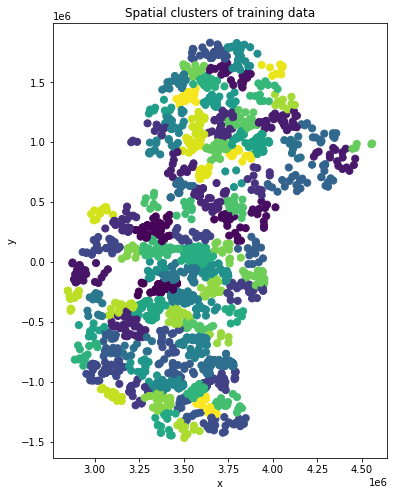

In [6]:
#create clustes
spatial_groups = spatial_clusters(coordinates=coordinates,
                                  method=cluster_method,
                                  max_distance=max_distance,
                                  n_groups=n_clusters,
                                  verbose=True)

#plot
plt.figure(figsize=(6,8))
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=spatial_groups,
            s=50, cmap='viridis');
plt.title('Spatial clusters of training data')
plt.ylabel('y')
plt.xlabel('x');

## Evaluating the classifier

Now that we're happy with the spatial clustering, we can evaluate the classifier via _nested_, spatial K-fold cross-validation.

The k-fold cross-validation procedure is used to estimate the performance of machine learning models when making predictions on data not used during training. However, when the same cross-validation procedure and dataset are used to both tune the hyperparameters and select a model, it is likely to lead to an optimistically biased evaluation of the model performance.

One approach to overcoming this bias is to nest the hyperparameter optimization procedure under the model selection procedure. This is called nested cross-validation and is the preferred way to evaluate and compare tuned machine learning models.
            
_Figure 1: Nested K-Fold Cross Validation_            
<img align="center" src="data/figs/nested_CV.png" width="400">

***

Before evaluating the model, we need to set up some hyperparameters to test during optimization.  The `param_grid` object below is set up to test various important hyperparameters for a Random Forest model. 

> **Note**: the parameters in the `param_grid` object depend on the classifier being used. This notebook is set up for a random forest classifier, to adjust the paramaters to suit a different classifier, look up the important parameters under the relevant [sklearn documentation](https://scikit-learn.org/stable/supervised_learning.html). 

In [7]:
# Create the parameter grid
param_grid = {
    'max_features': ['auto', 'log2', None],
    'n_estimators': [300,400,500],
    'criterion':['gini', 'entropy']
}

Now we will conduct the nested CV using the SKCV function. This will take a while to run depending on the number of inner and outer cv splits

In [8]:
# create outer k-fold splits
outer_cv = SKCV(
    coordinates=coordinates,
    max_distance=max_distance,
    n_splits=outer_cv_splits,
    cluster_method=cluster_method,
    kfold_method=kfold_method,
    test_size=test_size,
    balance=balance,
)

# lists to store results of CV testing
acc = []
f1 = []
roc_auc = []

# loop through outer splits and test predictions
i=1
for train_index, test_index in outer_cv.split(coordinates):
    print('working on '+str(i)+'/'+str(outer_cv_splits)+' outer cv split', end='\r')
    model = Classifier(random_state=1)

    # index training, testing, and coordinate data
    X_tr, X_tt = X[train_index, :], X[test_index, :]
    y_tr, y_tt = y[train_index], y[test_index]
    coords = coordinates[train_index]

    # inner split on data within outer split
    inner_cv = SKCV(
        coordinates=coords,
        max_distance=max_distance,
        n_splits=inner_cv_splits,
        cluster_method=cluster_method,
        kfold_method=kfold_method,
        test_size=test_size,
        balance=balance,
    )

    #optimize hyperparameters using innner splits
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=metric,
        n_jobs=ncpus,
        cv=inner_cv.split(coords),
        refit=True,
    )

    clf.fit(X_tr, y_tr)
    #predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # ROC AUC
    probs = best_model.predict_proba(X_tt)
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_tt, probs)
    auc_ = auc(fpr, tpr)
    roc_auc.append(auc_)
    # Overall accuracy
    ac = balanced_accuracy_score(y_tt, pred)
    acc.append(ac)
    # F1 scores
    f1_ = f1_score(y_tt, pred)
    f1.append(f1_)
    i+=1

#### The results of our model evaluation

In [9]:
print("=== Nested Spatial K-Fold Cross-Validation Scores ===")
print("Mean balanced accuracy: "+ str(round(np.mean(acc), 2)))
print("Std balanced accuracy: "+ str(round(np.std(acc), 2)))
print('\n')
print("Mean F1: "+ str(round(np.mean(f1), 2)))
print("Std F1: "+ str(round(np.std(f1), 2)))
print('\n')
print("Mean roc_auc: "+ str(round(np.mean(roc_auc), 3)))
print("Std roc_auc: "+ str(round(np.std(roc_auc), 2)))

=== Nested Spatial K-Fold Cross-Validation Scores ===
Mean balanced accuracy: 0.58
Std balanced accuracy: 0.05


Mean F1: 0.47
Std F1: 0.08


Mean roc_auc: 0.643
Std roc_auc: 0.07


These scores represent a robust estimate of the accuracy of our classifier. However, because we are using only a subset of data to fit and optimize the models, it is reasonable to expect these scores are an under-estimate of the final model's accuracy.  Also, the _map_ accuracy will differ from the accuracies reported here since the training data is not a perfect representation of the data in the real world (e.g. if we have purposively over-sampled from hard-to-classify regions, or if the proportions of crop to non-crop do not match the proportions in the real world). 

## Optimize hyperparameters

Hyperparameter searches are a required process in machine learning. Machine learning models require certain “hyperparameters”; model parameters that can be learned from the data. Finding good values for these parameters is a “hyperparameter search” or an “hyperparameter optimization.”

To optimize the parameters in our model, we use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to exhaustively search through a set of parameters and determine the combination that will result in the highest accuracy based upon the accuracy metric defined.


In [10]:
#generate n_splits of train-test_split
ss = SKCV(
        coordinates=coordinates,
        max_distance=max_distance,
        n_groups=n_clusters,
        n_splits=outer_cv_splits,
        cluster_method=cluster_method,
        kfold_method=kfold_method,
        test_size=test_size,
        balance=balance
        )

In [11]:
#instatiate a gridsearchCV
clf = GridSearchCV(Classifier(),
                   param_grid,
                   scoring=metric,
                   verbose=1,
                   cv=ss.split(coordinates),
                   n_jobs=ncpus)

clf.fit(X, y)

print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The "+metric+" score using these parameters is: ")
print(round(clf.best_score_, 2))

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=31)]: Using backend LokyBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done 180 out of 180 | elapsed:  2.5min finished


The most accurate combination of tested parameters is: 
{'criterion': 'gini', 'max_features': None, 'n_estimators': 300}


The balanced_accuracy score using these parameters is: 
0.63


## Fit a model

Using the best parameters from our hyperparmeter optmization search, we now fit our model on all the data to give the best possible model.

In [12]:
#create a new model
new_model = Classifier(**clf.best_params_, random_state=1, n_jobs=ncpus)
new_model.fit(X, y)

RandomForestClassifier(max_features=None, n_estimators=300, n_jobs=31,
                       random_state=1)

## Save the model

Running this cell will export the classifier as a binary`.joblib` file. This will allow for importing the model in the subsequent script, `4_Predict.ipynb` 


In [13]:
model_filename = 'results/gm_mads_two_seasons_ml_model_20201215_rainfall.joblib'

In [14]:
dump(new_model, model_filename)

['results/gm_mads_two_seasons_ml_model_20201215_rainfall.joblib']

## Next steps

To continue working through the notebooks in this `Eastern Africa Cropland Mask` workflow, go to the next notebook `4_Predict.ipynb`.

1. [Extracting_training_data](1_Extracting_training_data.ipynb) 
2. [Inspect_training_data](2_Inspect_training_data.ipynb)
3. **Train_fit_evaluate_classifier (this notebook)**
4. [Predict](4_Predict.ipynb)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Dec 2020
